In [114]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader
from sksurv.metrics import integrated_brier_score
from sksurv.util import Surv
from sklearn.model_selection import KFold

import nnet_survival_pytorch

In [115]:
df_train = pd.read_csv('our_data/imputed_train_nocat.csv')
df_train = df_train.drop(['X', 'PO_7', "PO_30", 'PO_60', 'PO_180', 'PO_365', "PO_730", 'PO_1460', 'subject_id'], axis = 1)

df_test = pd.read_csv('our_data/imputed_test_nocat.csv')
df_test = df_test.drop(['X', 'PO_7', "PO_30", 'PO_60', 'PO_180', 'PO_365', "PO_730", 'PO_1460', 'subject_id'], axis = 1)

breaks = np.array([0., 7., 30., 60., 180., 365., 730., 1460.])
n_intervals=len(breaks)-1

# print(breaks)
# print(df_train.head())
# print(df_train.columns)


X_train0 = df_train.drop(['survival_days', 'event'], axis = 1).to_numpy()
surtim_train = df_train['survival_days'].to_numpy()
surind_train = df_train['event'].to_numpy().astype(bool)


n_predictors = X_train0.shape[1]

X_test = df_test.drop(['survival_days', 'event'], axis = 1).to_numpy()
surtim_test = df_test['survival_days'].to_numpy()
surind_test = df_test['event'].to_numpy().astype(bool)

y_test = nnet_survival_pytorch.make_surv_array(surtim_test, surind_test, breaks)


In [116]:
class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        myItem = self.data[idx]
        myLabel = self.labels[idx]
        if self.transform:
            myItem = self.transform(myItem)
        myItem = torch.from_numpy(myItem).float()
        myLabel = torch.from_numpy(myLabel).float()
        return myItem, myLabel

In [117]:
def train(dataloader, model, loss_fn, optimizer, ds, si, st):
    times = np.append(breaks[1:-1], np.max(st) - 1)

    size = len(dataloader.dataset)
    model.train()
    train_loss = 0.0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        if torch.isnan(X).any():
            print("NaN detected in inputs")
        if torch.isinf(X).any():
            print("Inf detected in inputs")
        if torch.isnan(y).any():
            print("NaN detected in targets")
        if torch.isinf(y).any():
            print("Inf detected in targets")
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += loss.item()
        
    avg_train_loss = train_loss / size  # average loss for epoch

    y_pred=model(torch.tensor(ds).float().to(device)).squeeze().detach().cpu().numpy()
    y_true = Surv.from_arrays(event=si, time=st)
    ibs = integrated_brier_score(y_true, y_true, y_pred, times)

    return avg_train_loss, ibs


In [118]:
class SimpleSurvivalModel(nn.Module):
	def __init__(self, n_predictors, n_intervals):
		super(SimpleSurvivalModel, self).__init__()
		self.lin = nn.Linear(n_predictors, n_intervals)
	def forward(self, x):
		return F.sigmoid(self.lin(x))

In [119]:
device = ( #disabled mps because max_unpool2d not implemented yet
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [120]:
batch_size = 4
learning_rate = 0.001
epochs = 50
train_over_epoch = {}
ibs_over_epoch = {}
c_over_epoch = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train0)):
    print(f"\n=== Fold {fold+1} ===")

    X_train, X_val = X_train0[train_idx], X_train0[val_idx]
    tim_train, tim_val = surtim_train[train_idx], surtim_train[val_idx]
    ind_train, ind_val = surind_train[train_idx], surind_train[val_idx]


    y_train = nnet_survival_pytorch.make_surv_array(tim_train, ind_train, breaks)
    y_val = nnet_survival_pytorch.make_surv_array(tim_val, ind_val, breaks)

    train_dataset = MyDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = MyDataset(X_val, y_val)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    model = SimpleSurvivalModel(n_predictors=n_predictors, n_intervals=n_intervals).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    my_loss = nnet_survival_pytorch.surv_likelihood(n_intervals)
    
    training_loss = []
    ibs_epoch = []
    for epoch in range(epochs):
        if epoch % 5 == 0:
            print(f"Epoch {epoch+1}\n-------------------------------")
        train_loss, ibs = train(train_dataloader, model, my_loss, optimizer, X_train, ind_train, tim_train)
        training_loss.append(train_loss)
        ibs_epoch.append(ibs)

    train_over_epoch[fold] = training_loss
    ibs_over_epoch[fold] = ibs_epoch
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        
        val_pred = model(torch.tensor(X_val).float().to(device)).squeeze().detach().cpu().numpy()

        result = np.apply_along_axis(np.minimum.accumulate, axis=0, arr=val_pred)

        # print(result.shape)
        c_indices = []
        for i in range(val_pred.shape[1]):
            s_pred = result[:, i]
        
            c_index = concordance_index(tim_val, -s_pred, ind_val)
            c_indices.append(c_index)
            print(f'C-index (interval {i})', c_index)
            
    c_over_epoch[fold] = c_indices




=== Fold 1 ===
Epoch 1
-------------------------------
Epoch 6
-------------------------------
Epoch 11
-------------------------------
Epoch 16
-------------------------------
Epoch 21
-------------------------------
Epoch 26
-------------------------------
Epoch 31
-------------------------------
Epoch 36
-------------------------------
Epoch 41
-------------------------------
Epoch 46
-------------------------------
C-index (interval 0) 0.5347490347490348
C-index (interval 1) 0.5
C-index (interval 2) 0.5
C-index (interval 3) 0.5797940797940798
C-index (interval 4) 0.5263835263835264
C-index (interval 5) 0.5373230373230373
C-index (interval 6) 0.5064350064350064

=== Fold 2 ===
Epoch 1
-------------------------------
Epoch 6
-------------------------------
Epoch 11
-------------------------------
Epoch 16
-------------------------------
Epoch 21
-------------------------------
Epoch 26
-------------------------------
Epoch 31
-------------------------------
Epoch 36
----------------

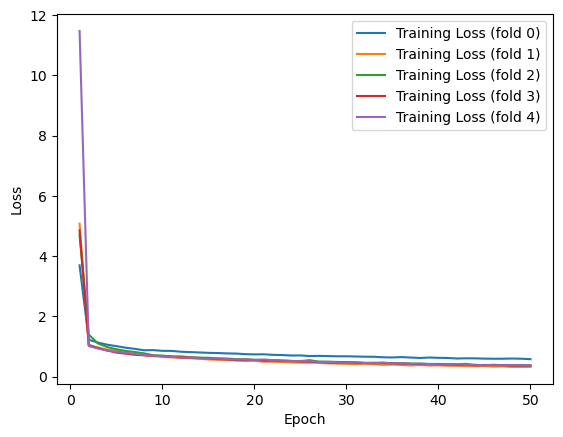

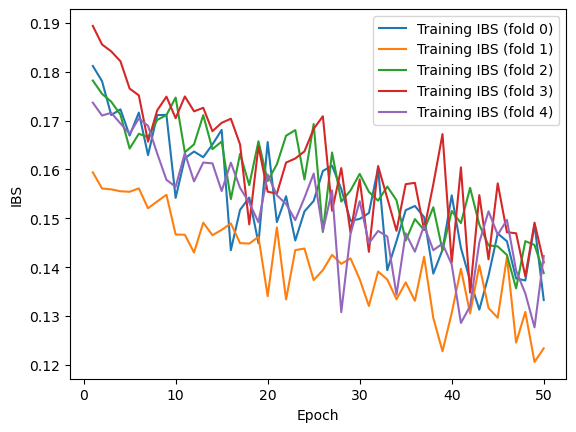

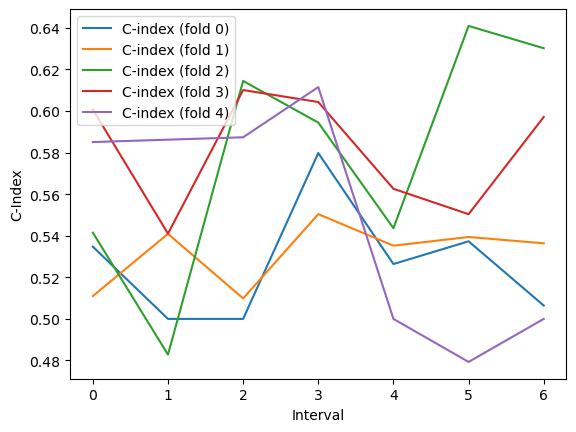

Mean C-index across folds: [0.55459972 0.53019116 0.56434519 0.58808085 0.5335669  0.54946053
 0.55402138]
Standard deviation: [0.03323531 0.03612191 0.0494794  0.02164298 0.02061442 0.05202796
 0.05128997]


In [121]:
epochs = range(1, 50 + 1)

plt.figure()
for i in range(5):
    plt.plot(epochs, train_over_epoch[i], label = f"Training Loss (fold {i})")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
for i in range(5):
    plt.plot(epochs, ibs_over_epoch[i], label = f"Training IBS (fold {i})")
plt.xlabel('Epoch')
plt.ylabel('IBS')
plt.legend()
plt.show()

plt.figure()
for i in range(5):
    plt.plot(list(range(7)), c_over_epoch[i], label = f"C-index (fold {i})")
plt.xlabel('Interval')
plt.ylabel('C-Index')
plt.legend()
plt.show()

c_array = np.array([c_over_epoch[key] for key in c_over_epoch.keys()])

print("Mean C-index across folds:", np.mean(c_array, axis = 0))
print("Standard deviation:", np.std(c_array, axis = 0))


In [122]:
class SimpleSurvivalModel2(nn.Module):
    def __init__(self, n_predictors, n_intervals):
        super(SimpleSurvivalModel2, self).__init__()
        self.lin = nn.Linear(n_predictors, 8)
        self.lin2 = nn.Linear(8, n_intervals)

    def forward(self, x):
        x = F.gelu(self.lin(x))
        x = F.sigmoid(self.lin2(x))  # Use torch.sigmoid instead of F.sigmoid (deprecated)
        return x

In [123]:
batch_size = 4
learning_rate = 0.001
epochs = 50
train_over_epoch = {}
ibs_over_epoch = {}
c_over_epoch = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train0)):
    print(f"\n=== Fold {fold+1} ===")

    X_train, X_val = X_train0[train_idx], X_train0[val_idx]
    tim_train, tim_val = surtim_train[train_idx], surtim_train[val_idx]
    ind_train, ind_val = surind_train[train_idx], surind_train[val_idx]


    y_train = nnet_survival_pytorch.make_surv_array(tim_train, ind_train, breaks)
    y_val = nnet_survival_pytorch.make_surv_array(tim_val, ind_val, breaks)

    train_dataset = MyDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = MyDataset(X_val, y_val)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    model = SimpleSurvivalModel2(n_predictors=n_predictors, n_intervals=n_intervals).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    my_loss = nnet_survival_pytorch.surv_likelihood(n_intervals)
    
    training_loss = []
    ibs_epoch = []
    for epoch in range(epochs):
        if epoch % 5 == 0:
            print(f"Epoch {epoch+1}\n-------------------------------")
        train_loss, ibs = train(train_dataloader, model, my_loss, optimizer, X_train, ind_train, tim_train)
        training_loss.append(train_loss)
        ibs_epoch.append(ibs)

    train_over_epoch[fold] = training_loss
    ibs_over_epoch[fold] = ibs_epoch
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        
        val_pred = model(torch.tensor(X_val).float().to(device)).squeeze().detach().cpu().numpy()

        result = np.apply_along_axis(np.minimum.accumulate, axis=0, arr=val_pred)

        # print(result.shape)
        c_indices = []
        for i in range(val_pred.shape[1]):
            s_pred = result[:, i]
        
            c_index = concordance_index(tim_val, -s_pred, ind_val)
            c_indices.append(c_index)
            print(f'C-index (interval {i})', c_index)
            
    c_over_epoch[fold] = c_indices




=== Fold 1 ===
Epoch 1
-------------------------------
Epoch 6
-------------------------------
Epoch 11
-------------------------------
Epoch 16
-------------------------------
Epoch 21
-------------------------------
Epoch 26
-------------------------------
Epoch 31
-------------------------------
Epoch 36
-------------------------------
Epoch 41
-------------------------------
Epoch 46
-------------------------------
C-index (interval 0) 0.5952380952380952
C-index (interval 1) 0.5797940797940798
C-index (interval 2) 0.584942084942085
C-index (interval 3) 0.49871299871299873
C-index (interval 4) 0.5
C-index (interval 5) 0.5424710424710425
C-index (interval 6) 0.5032175032175032

=== Fold 2 ===
Epoch 1
-------------------------------
Epoch 6
-------------------------------
Epoch 11
-------------------------------
Epoch 16
-------------------------------
Epoch 21
-------------------------------
Epoch 26
-------------------------------
Epoch 31
-------------------------------
Epoch 36
-

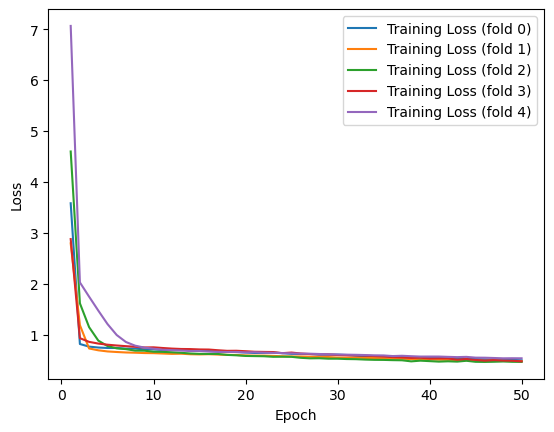

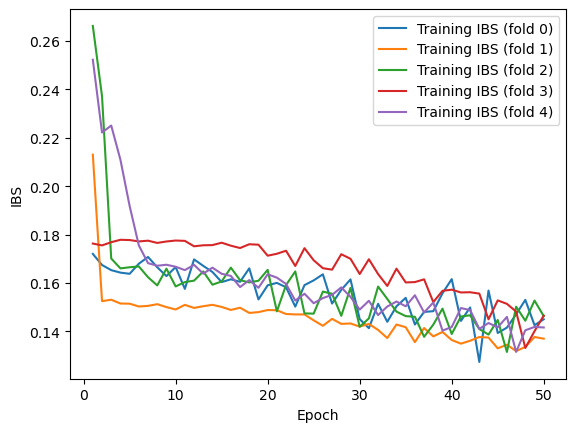

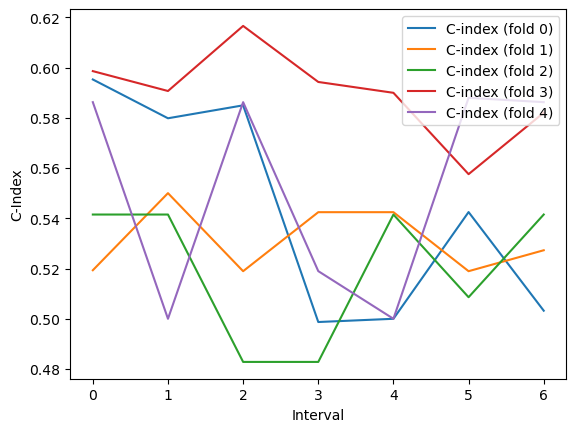

Mean C-index across folds: [0.56816243 0.55238588 0.55789355 0.527436   0.53476803 0.54309582
 0.54803987]
Standard deviation: [0.03187498 0.03188699 0.04924437 0.0389211  0.03335876 0.02826392
 0.03191939]


In [124]:
epochs = range(1, 50 + 1)

plt.figure()
for i in range(5):
    plt.plot(epochs, train_over_epoch[i], label = f"Training Loss (fold {i})")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
for i in range(5):
    plt.plot(epochs, ibs_over_epoch[i], label = f"Training IBS (fold {i})")
plt.xlabel('Epoch')
plt.ylabel('IBS')
plt.legend()
plt.show()

plt.figure()
for i in range(5):
    plt.plot(list(range(7)), c_over_epoch[i], label = f"C-index (fold {i})")
plt.xlabel('Interval')
plt.ylabel('C-Index')
plt.legend()
plt.show()

c_array = np.array([c_over_epoch[key] for key in c_over_epoch.keys()])

print("Mean C-index across folds:", np.mean(c_array, axis = 0))
print("Standard deviation:", np.std(c_array, axis = 0))

In [136]:
class SimpleSurvivalModel3(nn.Module):
    def __init__(self, n_predictors, n_intervals):
        super(SimpleSurvivalModel3, self).__init__()
        self.lin = nn.Linear(n_predictors, 64)
        self.lin2 = nn.Linear(64, n_intervals)

    def forward(self, x):
        x = F.gelu(self.lin(x))
        x = F.sigmoid(self.lin2(x))  # Use torch.sigmoid instead of F.sigmoid (deprecated)
        return x

In [138]:
batch_size = 4
learning_rate = 0.001
epochs = 50
train_over_epoch = {}
ibs_over_epoch = {}
c_over_epoch = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train0)):
    print(f"\n=== Fold {fold+1} ===")

    X_train, X_val = X_train0[train_idx], X_train0[val_idx]
    tim_train, tim_val = surtim_train[train_idx], surtim_train[val_idx]
    ind_train, ind_val = surind_train[train_idx], surind_train[val_idx]


    y_train = nnet_survival_pytorch.make_surv_array(tim_train, ind_train, breaks)
    y_val = nnet_survival_pytorch.make_surv_array(tim_val, ind_val, breaks)

    train_dataset = MyDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = MyDataset(X_val, y_val)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    model = SimpleSurvivalModel3(n_predictors=n_predictors, n_intervals=n_intervals).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    my_loss = nnet_survival_pytorch.surv_likelihood(n_intervals)
    
    training_loss = []
    ibs_epoch = []
    for epoch in range(epochs):
        if epoch % 5 == 0:
            print(f"Epoch {epoch+1}\n-------------------------------")
        train_loss, ibs = train(train_dataloader, model, my_loss, optimizer, X_train, ind_train, tim_train)
        training_loss.append(train_loss)
        ibs_epoch.append(ibs)

    train_over_epoch[fold] = training_loss
    ibs_over_epoch[fold] = ibs_epoch
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        
        val_pred = model(torch.tensor(X_val).float().to(device)).squeeze().detach().cpu().numpy()

        result = np.apply_along_axis(np.minimum.accumulate, axis=0, arr=val_pred)

        # print(result.shape)
        c_indices = []
        for i in range(val_pred.shape[1]):
            s_pred = result[:, i]
        
            c_index = concordance_index(tim_val, -s_pred, ind_val)
            c_indices.append(c_index)
            print(f'C-index (interval {i})', c_index)
            
    c_over_epoch[fold] = c_indices




=== Fold 1 ===
Epoch 1
-------------------------------
Epoch 6
-------------------------------
Epoch 11
-------------------------------
Epoch 16
-------------------------------
Epoch 21
-------------------------------
Epoch 26
-------------------------------
Epoch 31
-------------------------------
Epoch 36
-------------------------------
Epoch 41
-------------------------------
Epoch 46
-------------------------------
C-index (interval 0) 0.5353925353925354
C-index (interval 1) 0.5231660231660231
C-index (interval 2) 0.5
C-index (interval 3) 0.46846846846846846
C-index (interval 4) 0.5785070785070785
C-index (interval 5) 0.49356499356499356
C-index (interval 6) 0.5057915057915058

=== Fold 2 ===
Epoch 1
-------------------------------
Epoch 6
-------------------------------
Epoch 11
-------------------------------
Epoch 16
-------------------------------
Epoch 21
-------------------------------
Epoch 26
-------------------------------
Epoch 31
-------------------------------
Epoch 36

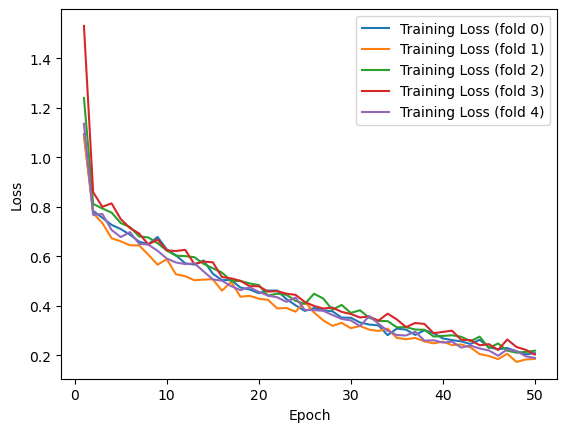

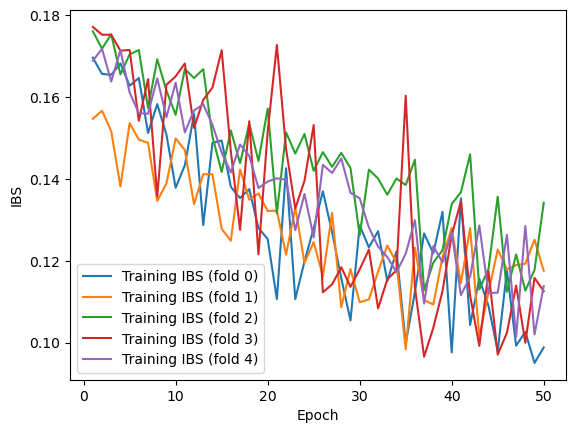

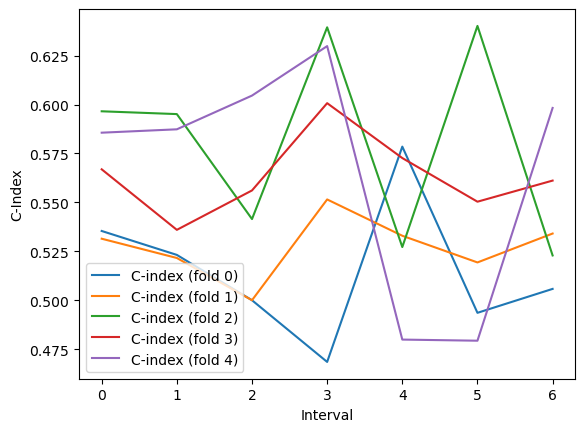

Mean C-index across folds: [0.56318742 0.55264408 0.54044013 0.57801462 0.53823805 0.5365507
 0.54443984]
Standard deviation: [0.02612377 0.03200542 0.03907379 0.06274908 0.03567022 0.05719286
 0.03238141]


In [140]:
epochs = range(1, 50 + 1)

plt.figure()
for i in range(5):
    plt.plot(epochs, train_over_epoch[i], label = f"Training Loss (fold {i})")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
for i in range(5):
    plt.plot(epochs, ibs_over_epoch[i], label = f"Training IBS (fold {i})")
plt.xlabel('Epoch')
plt.ylabel('IBS')
plt.legend()
plt.show()

plt.figure()
for i in range(5):
    plt.plot(list(range(7)), c_over_epoch[i], label = f"C-index (fold {i})")
plt.xlabel('Interval')
plt.ylabel('C-Index')
plt.legend()
plt.show()

c_array = np.array([c_over_epoch[key] for key in c_over_epoch.keys()])

print("Mean C-index across folds:", np.mean(c_array, axis = 0))
print("Standard deviation:", np.std(c_array, axis = 0))

In [144]:
class SimpleSurvivalModel4(nn.Module):
    def __init__(self, n_predictors, n_intervals):
        super(SimpleSurvivalModel4, self).__init__()
        self.lin = nn.Linear(n_predictors, 8)
        self.lin2 = nn.Linear(8, 8)
        self.lin3 = nn.Linear(8, n_intervals)

    def forward(self, x):
        x = F.gelu(self.lin(x))
        x = F.gelu(self.lin2(x))
        x = F.sigmoid(self.lin3(x))
        return x

In [146]:
batch_size = 4
learning_rate = 0.001
epochs = 50
train_over_epoch = {}
ibs_over_epoch = {}
c_over_epoch = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train0)):
    print(f"\n=== Fold {fold+1} ===")

    X_train, X_val = X_train0[train_idx], X_train0[val_idx]
    tim_train, tim_val = surtim_train[train_idx], surtim_train[val_idx]
    ind_train, ind_val = surind_train[train_idx], surind_train[val_idx]


    y_train = nnet_survival_pytorch.make_surv_array(tim_train, ind_train, breaks)
    y_val = nnet_survival_pytorch.make_surv_array(tim_val, ind_val, breaks)

    train_dataset = MyDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = MyDataset(X_val, y_val)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    model = SimpleSurvivalModel4(n_predictors=n_predictors, n_intervals=n_intervals).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    my_loss = nnet_survival_pytorch.surv_likelihood(n_intervals)
    
    training_loss = []
    ibs_epoch = []
    for epoch in range(epochs):
        if epoch % 5 == 0:
            print(f"Epoch {epoch+1}\n-------------------------------")
        train_loss, ibs = train(train_dataloader, model, my_loss, optimizer, X_train, ind_train, tim_train)
        training_loss.append(train_loss)
        ibs_epoch.append(ibs)

    train_over_epoch[fold] = training_loss
    ibs_over_epoch[fold] = ibs_epoch
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        
        val_pred = model(torch.tensor(X_val).float().to(device)).squeeze().detach().cpu().numpy()

        result = np.apply_along_axis(np.minimum.accumulate, axis=0, arr=val_pred)

        # print(result.shape)
        c_indices = []
        for i in range(val_pred.shape[1]):
            s_pred = result[:, i]
        
            c_index = concordance_index(tim_val, -s_pred, ind_val)
            c_indices.append(c_index)
            print(f'C-index (interval {i})', c_index)
            
    c_over_epoch[fold] = c_indices




=== Fold 1 ===
Epoch 1
-------------------------------
Epoch 6
-------------------------------
Epoch 11
-------------------------------
Epoch 16
-------------------------------
Epoch 21
-------------------------------
Epoch 26
-------------------------------
Epoch 31
-------------------------------
Epoch 36
-------------------------------
Epoch 41
-------------------------------
Epoch 46
-------------------------------
C-index (interval 0) 0.5019305019305019
C-index (interval 1) 0.5025740025740025
C-index (interval 2) 0.5128700128700129
C-index (interval 3) 0.4749034749034749
C-index (interval 4) 0.536036036036036
C-index (interval 5) 0.536036036036036
C-index (interval 6) 0.4749034749034749

=== Fold 2 ===
Epoch 1
-------------------------------
Epoch 6
-------------------------------
Epoch 11
-------------------------------
Epoch 16
-------------------------------
Epoch 21
-------------------------------
Epoch 26
-------------------------------
Epoch 31
-----------------------------

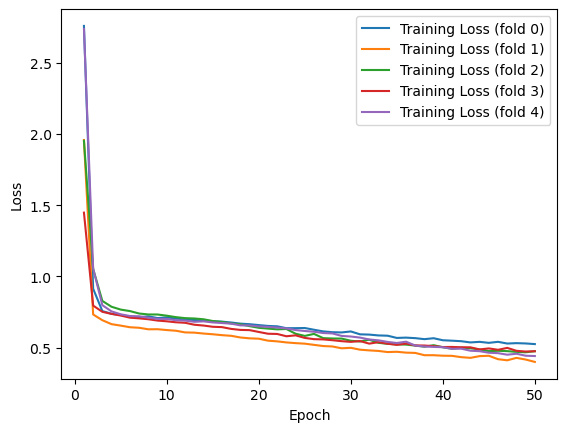

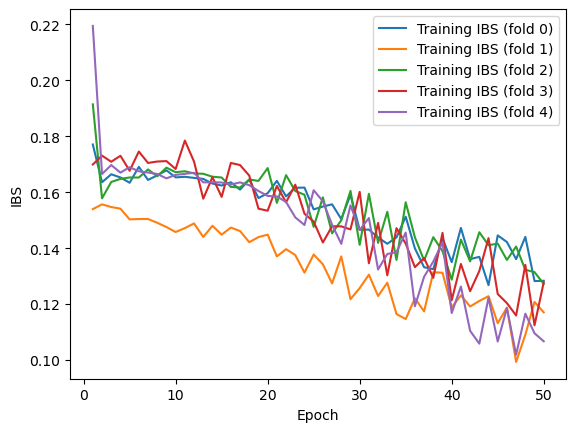

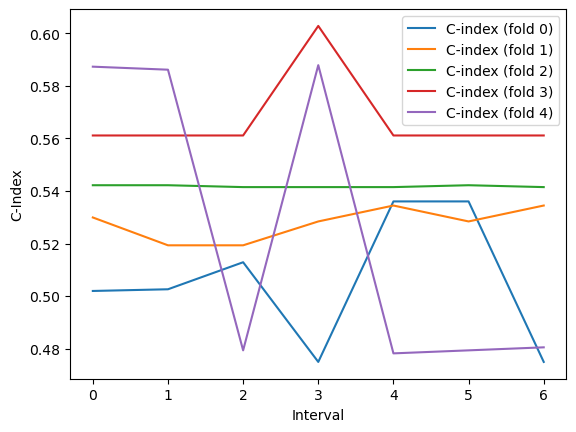

Mean C-index across folds: [0.54451306 0.54229066 0.52282749 0.54712183 0.53026111 0.52942194
 0.51849437]
Standard deviation: [0.02878823 0.0296294  0.0276482  0.0455445  0.02773345 0.0272985
 0.03449725]


In [148]:
epochs = range(1, 50 + 1)

plt.figure()
for i in range(5):
    plt.plot(epochs, train_over_epoch[i], label = f"Training Loss (fold {i})")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
for i in range(5):
    plt.plot(epochs, ibs_over_epoch[i], label = f"Training IBS (fold {i})")
plt.xlabel('Epoch')
plt.ylabel('IBS')
plt.legend()
plt.show()

plt.figure()
for i in range(5):
    plt.plot(list(range(7)), c_over_epoch[i], label = f"C-index (fold {i})")
plt.xlabel('Interval')
plt.ylabel('C-Index')
plt.legend()
plt.show()

c_array = np.array([c_over_epoch[key] for key in c_over_epoch.keys()])

print("Mean C-index across folds:", np.mean(c_array, axis = 0))
print("Standard deviation:", np.std(c_array, axis = 0))